# dataretrieval Overview

## What is dataretrieval?
`dataretrieval` was created to simplify the process of loading hydrologic data into the Python environment.
Like the original R version [`dataRetrieval`](https://github.com/DOI-USGS/dataRetrieval),
it is designed to retrieve the major data types of U.S. Geological Survey (USGS) hydrology
data that are available on the Web, as well as data from the Water
Quality Portal (WQP), which currently houses water quality data from the
Environmental Protection Agency (EPA), U.S. Department of Agriculture
(USDA), and USGS.

By the end of this tutorial, you should be comfortable using the `dataretrieval` package to query
water data from USGS or the multi-agency Water Quality Portal. The tutorial also demonstrates several simple but versitile patterns for cleaning and visualizing those data.

## Installation

`dataretrieval` is available on the Python Package Index (PyPI).
If it is not included in your Python environment, install it from PyPI

```bash
pip install dataretrieval
```
or `conda-forge`
```bash
conda install -c conda-forge dataretrieval
```

## NWIS module
This notebook introduces the `dataretrieva.nwis` module, which contains functions for querying USGS's National Water Information System (NWIS).

### Warning
As of March 2024, all discrete water quality USGS data should be obtained from the Water Quality Portal (WQP). WQP retrievals will be covered below. Lots of changes are happening with USGS water quality data and Water Quality Portal data formatting.

Begin by importing the `dataretrieval.nwis` module.

In [1]:
from dataretrieval import nwis

The user functions in the `nwis` module are prefixed with `get_`.
The one exception is the  function `what_sites`, but it's just `get_info`

To get a sense of what's available, we can list any function name including the strings 'get' or 'what':

In [2]:
[i  for i in dir(nwis) if 'get' in i or 'what' in i]

['get_discharge_measurements',
 'get_discharge_peaks',
 'get_dv',
 'get_gwlevels',
 'get_info',
 'get_iv',
 'get_pmcodes',
 'get_qwdata',
 'get_ratings',
 'get_record',
 'get_stats',
 'get_water_use',
 'what_sites']

(note: we can view a function's doc using `help(nwis.get_dv)` or `nwis.get_dv?`

In [3]:
nwis.get_dv?

Signature:
nwis.get_dv(
    sites: Union[List[str], str, NoneType] = None,
    start: Optional[str] = None,
    end: Optional[str] = None,
    multi_index: bool = True,
    ssl_check: bool = True,
    **kwargs,
) -> Tuple[pandas.core.frame.DataFrame, dataretrieval.utils.BaseMetadata]
Docstring:
Get daily values data from NWIS and return it as a ``pandas.DataFrame``.

.. note:

    If no start or end date are provided, only the most recent record
    is returned.

Parameters
----------
sites: string or list of strings, optional, default is None
    USGS site number (or list of site numbers)
start: string, optional, default is None
    If the waterdata parameter startDT is supplied, it will overwrite the
    start parameter (YYYY-MM-DD)
end: string, optional, default is None
    If the waterdata parameter endDT is supplied, it will overwrite the
    end parameter (YYYY-MM-DD)
multi_index: bool, optional
    If True, return a multi-index dataframe, if False, return a
    single-index data

## National Water Information System (NWIS)  Retrievals
USGS water data is housed in the National Water Information System (NWIS). 
There are many types of data served from NWIS. 
NWIS serves several types of data, but before we dive into these services, it's helpful to understand some codes.

The USGS uses various codes for basic retrievals. These codes can have leading zeros, therefore in Python they need to be strings ("01234567").

* Site ID (often 8 or 15-digits)
* Parameter Code (5 digits)
    + Full list: [https://nwis.waterdata.usgs.gov/usa/nwis/pmcodes](https://nwis.waterdata.usgs.gov/usa/nwis/pmcodes)
    + Alternatively use `nwis.get_pmcodes("all")`
* Statistic Code (for daily values)
    + Full list: [http://help.waterdata.usgs.gov/code/stat_cd_nm_query?stat_nm_cd=%25&fmt=html](http://help.waterdata.usgs.gov/code/stat_cd_nm_query?stat_nm_cd=%25&fmt=html)

`dataretrieval` queries return data as a `pandas.DataFrame`,
which is convenient for many types of analysis.
However, a dataframes have limited support for metadata.
As a result, `dataretrieval` functions typically return a tuple of two elements: the dataframe and its metadata.

In [4]:
df, meta = nwis.get_pmcodes("00060"); df

,parameter_cd,group,parm_nm,epa_equivalence,result_statistical_basis,result_time_basis,result_weight_basis,result_particle_size_basis,result_sample_fraction,result_temperature_basis,CASRN,SRSName,parm_unit
0,00060,Physical,"Discharge, cubic feet per second",Not checked,Mean,1 Day,NaN,NaN,NaN,NaN,,"Stream flow, mean. daily",ft3/s


Here a few of the most common parameter codes

| Code  | Name         |
| ------| ------------ |
|00060  | Discharge    |
|00065  | Gage Height  |
|00010	| Temperature  |
|00400	| pH           |

And here are a few common statistic codes

| Code  | Name         |
| ------| ------------ |
|00001  | Maximum      |
|00002  | Minimum      |
|00003	| Mean         |
|00008	| Median       |


The `nwis.get_pmcodes` function returns information on USGS parameter codes. 
You can use "all" to get a full list, then filter out those of interest.

In [5]:
df, _ = nwis.get_pmcodes("all")

Here is one example to find all the phosphorous parameter codes:

In [6]:
df[df.parm_nm.str.contains('Phosphorus', case=False)].head(10)

,parm_cd,group,parm_nm,epa_equivalence,result_statistical_basis,result_time_basis,result_weight_basis,result_particle_size_basis,result_sample_fraction,result_temperature_basis,CASRN,SRSName,parm_unit
208,00662,Nutrient,"Phosphorus, water, unfiltered, recoverable, mi...",Agree,NaN,NaN,NaN,NaN,Recoverable,NaN,7723-14-0,,ug/l as P
209,00665,Nutrient,"Phosphorus, water, unfiltered, milligrams per ...",Agree,NaN,NaN,NaN,NaN,Total,NaN,7723-14-0,Phosphorus,mg/l as P
210,00666,Nutrient,"Phosphorus, water, filtered, milligrams per li...",Agree,NaN,NaN,NaN,NaN,Dissolved,NaN,7723-14-0,Phosphorus,mg/l as P
211,00667,Nutrient,"Phosphorus, suspended sediment, total, milligr...",Agree,NaN,NaN,NaN,NaN,Suspended,NaN,7723-14-0,Phosphorus,mg/l as P
212,00668,Nutrient,"Phosphorus, bed sediment, total, dry weight, m...",Agree,NaN,NaN,Dry,NaN,Bed Sediment,NaN,7723-14-0,Phosphorus,mg/kg as P
213,00669,Nutrient,"Hydrolyzable phosphorus, water, unfiltered, mi...",Agree,NaN,NaN,NaN,NaN,Total,NaN,,,mg/l as P
214,00670,Nutrient,"Organic phosphorus, water, unfiltered, milligr...",Agree,NaN,NaN,NaN,NaN,Total,NaN,,Organic phosphorus,mg/l as P
215,00671,Nutrient,"Orthophosphate, water, filtered, milligrams pe...",Agree,NaN,NaN,NaN,NaN,Dissolved,NaN,14265-44-2,Phosphate,mg/l as P
216,00672,Nutrient,"Hydrolyzable phosphorus, water, filtered, mill...",Agree,NaN,NaN,NaN,NaN,Dissolved,NaN,,,mg/l as P
217,00673,Nutrient,"Organic phosphorus, water, filtered, milligram...",Agree,NaN,NaN,NaN,NaN,Dissolved,NaN,,Organic phosphorus,mg/l as P


## Timeseries query


In [7]:
site = "05427948"
pcode = "00060"
start = "2017-10-01"
end = "2024-05-30"


df, meta = nwis.get_dv(
    sites = site,
    start = start,
    end = end,
    parameterCd = pcode, # kwarg passed to NWIS API
)

Unless your application requires high-frequency (sub daily) data,
I recommend you start with daily values.
- Daily datasets are smaller,faster to download, and consume less memory.
- Instantaneous data commonly have more gaps necessitating extra processing,
- Missing daily values are estimated and flagged with an 'e'.

From the Pheasant Creek example, let’s look at the data.

In [8]:
df

,site_no,00060_Mean,00060_Mean_cd
datetime,,,
2017-10-01 00:00:00+00:00,05427948,2.76,A
2017-10-02 00:00:00+00:00,05427948,3.02,A
2017-10-03 00:00:00+00:00,05427948,3.28,A
2017-10-04 00:00:00+00:00,05427948,13.30,A
2017-10-05 00:00:00+00:00,05427948,6.93,"A, e"
...,...,...,...
2024-05-26 00:00:00+00:00,05427948,37.70,P
2024-05-27 00:00:00+00:00,05427948,37.00,P
2024-05-28 00:00:00+00:00,05427948,16.20,P


In [9]:
meta # the class _repr_ displays the query url

NWIS_Metadata(url=https://waterservices.usgs.gov/nwis/dv?format=json&parameterCd=00060&startDT=2017-10-01&endDT=2024-05-30&sites=05427948)

The metadata records the query url, which can be useful for debugging,
as well as the date and time of the query.

In [10]:
meta.header

{'Date': 'Tue, 04 Jun 2024 16:11:22 GMT', 'Server': 'Apache-Coyote/1.1', 'Strict-Transport-Security': 'max-age=31536000', 'Vary': 'Accept-Encoding', 'Content-Encoding': 'gzip', 'Content-Type': 'application/json', 'Cache-Control': 'max-age=900', 'Expires': 'Tue, 04 Jun 2024 16:26:22 GMT', 'X-UA-Compatible': 'IE=edge,chrome=1', 'Access-Control-Allow-Origin': '*', 'X-Frame-Options': 'deny', 'Keep-Alive': 'timeout=5, max=100', 'Connection': 'Keep-Alive', 'Transfer-Encoding': 'chunked'}

Now let's use `pandas` built-in plotting to visualize our query results.

<Axes: xlabel='datetime'>

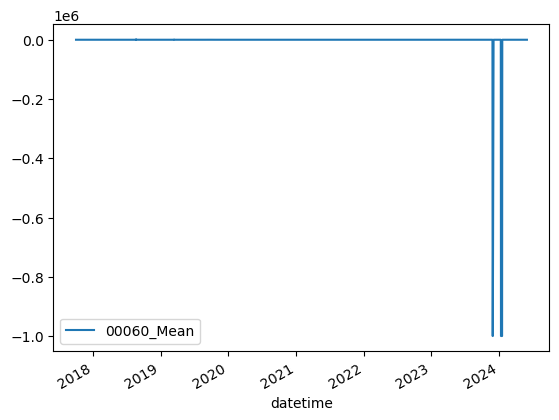

In [11]:
df.plot()

Uh oh. If your plot looks strange, you might filter the "approved" data

<Axes: xlabel='datetime'>

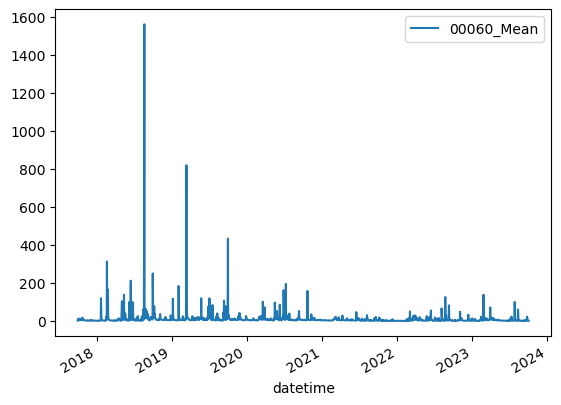

In [12]:
df.loc[~df['00060_Mean_cd'].str.contains('A')] = None
df.plot()

Better!

When doing some initial exploration, it's much nicer to have interactive plots. 
Python has a diverse plotting ecosystem.
Most libraries will try to give a `matplotlib`-like experience. For example, `pandas` plotting uses `matplotlib` backend by default with many of the same arguments. 
For this reason, Python programmers generally learn `matplotlib` before experimenting with other libraries.
But the other libraries are extremely good too. Here we'll demonstrate `hvplot` for interactive plotting, which has good integration with `pandas` and `xarray`.

In [13]:
import hvplot.pandas

df.hvplot() # add the letters "hv"

# or
# pd.options.plotting.backend = "holoviews"

:Curve   [datetime]   (00060_Mean)

Here's another common "gotcha":

<Axes: xlabel='datetime'>

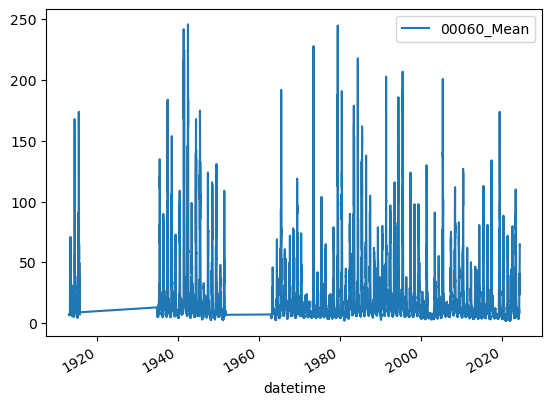

In [25]:
from dataretrieval import nwis

df, metadata = nwis.get_dv(site = '08271000', start='1900-01-01')
df.plot()

This record has gaps. To correct it, we populate those missing periods with nans.
This is fairly easy for single sites:

<Axes: xlabel='datetime'>

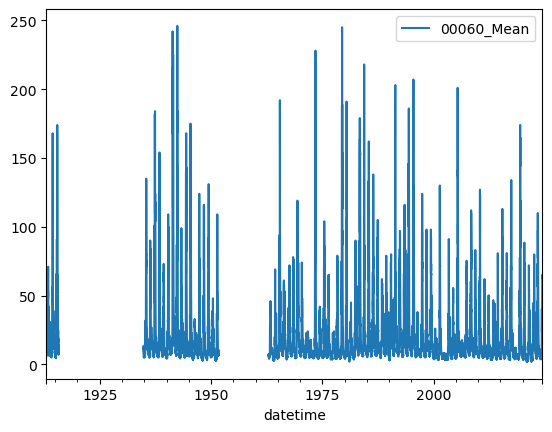

In [26]:
# fill the missing data with nans
df.asfreq(freq='D').plot()

But queries returning multiple sites are trickier. In fairness, `pandas.MultiIndex` can make simple tasks tricky in general.

In [32]:
df, _ = nwis.get_dv(sites=["08271000", "08267500"], parameterCd="00060", start="1901-01-01")
df.head()

00060_Mean 00060_Mean_cd
site_no  datetime                                           
08267500 1934-10-01 00:00:00+00:00        16.0             A
         1934-10-02 00:00:00+00:00        18.0             A
         1934-10-03 00:00:00+00:00        21.0             A
         1934-10-04 00:00:00+00:00        23.0             A
         1934-10-05 00:00:00+00:00        22.0             A

For example, how would you go about nan-ing the multi-site dataframe?
Can you find a solution to this "simple" problem?

In [34]:
# will return an error
df.asfreq(freq='D')

TypeError: Cannot convert input [('08267500', Timestamp('1934-10-01 00:00:00+0000', tz='UTC'))] of type <class 'tuple'> to Timestamp

## Query site information
Sometimes we need metadata about a monitoring location.
For this we can use `nwis.get_info` or `nwis.what_sites`,
which are actually the same function with different names.

We can pull metadata for a single location.

In [17]:
site = "05407000"
df, meta = nwis.what_sites(sites=site)

df

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd
0,USGS,05407000,"WISCONSIN RIVER AT MUSCODA, WI",ST,43.198056,-90.443333,S,NAD83,666.55,0.01,NAVD88,7070005


Or construct a multi-location query by providing list of site codes, a state code, or a bounding box.

This query will return all stations with data on a particular parameter in one state.

In [28]:
state_cd = "IL"
parameter_cd = "00665" # USGS code for total phosphorus
df, meta = nwis.what_sites(
    stateCd=state_cd, 
    parameterCd=parameter_cd,
)

Just as a quick example, let's visualizing those sites on an interactive map.

In [30]:
import geopandas as gpd
import hvplot.pandas

geometry = gpd.points_from_xy(df.dec_long_va, df.dec_lat_va)
gdf = gpd.GeoDataFrame(df, geometry=geometry)

gdf.hvplot.points(
    geo=True,
    hover_cols=["site_no", "station_nm"],
    tiles=True,
    frame_width=300,
    size=4,
)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (site_no,station_nm)

A typical workflow might begin by downloading data from these sites.
Think 

In [20]:
df, _ = nwis.get_qwdata(df.site_no.to_list())

/Users/thodson/Desktop/dev/software/dataretrieval-python/dataretrieval/nwis.py:180: UserWarning: WARNING: Starting in March 2024, the NWIS qw data endpoint is retiring and no longer receives updates. For more information, refer to https://waterdata.usgs.gov.nwis/qwdata and https://doi-usgs.github.io/dataRetrieval/articles/Status.html or email CompTools@usgs.gov.
  warnings.warn(('WARNING: Starting in March 2024, the NWIS qw data endpoint is '


ValueError: Request URL too long. Modify your query to use fewer sites. API response reason: Request-URI Too Long. Pseudo-code example of how to split your query: 
 
                    # n is the number of chunks to divide the query into 

                    split_list = np.array_split(site_list, n)
                    data_list = []  # list to store chunk results in 

                    # loop through chunks and make requests 

                    for site_list in split_list: 

                        data = nwis.get_record(sites=site_list, service='dv', 

                                               start=start, end=end) 

                        data_list.append(data)  # append results to list

That query probably didn't work for you.
In general, `dataretrieval` follows the KISS philosophy:
we won't make up for limitations in the web service; that's up to you.
In this case, we provide an error message with a pseudo-code solution,
whereas `hyriver` would fix this behind the scenes.
But QWData is going the way of the dinosaurs, and going forward you should be pulling these data from Water Quality Portal (WQP),
which we demonstration in the next [notebook](www.google.com) TODO.